<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula06a_multiclasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

def plotDataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y)

In [2]:
def plotHiperplano(vector, intercept=0, dataset=None):
  xs = np.array([0, 1])
  ys = -(vector[0]*xs+intercept)/vector[1]
  plt.plot(xs, ys, 'r-')

In [3]:
def sign(a):
  return (a>=0)*2-1

In [4]:
import numpy as np
from sklearn.datasets import make_blobs

def criaDatasetMulticlasse(n=40, n_classes=4):
  X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0,1), cluster_std=0.02)
  return X, y

X, y = criaDatasetMulticlasse()

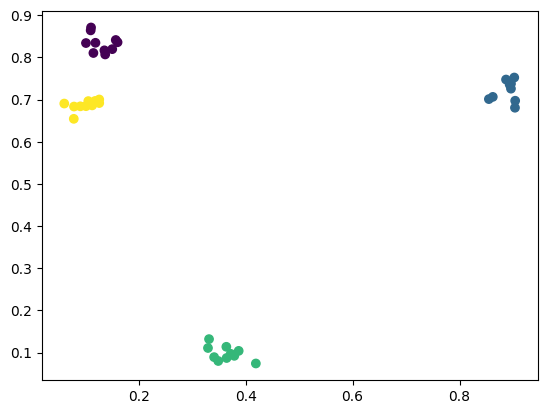

In [5]:
plotDataset(X, y)
plt.show()

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

In [7]:
include_bias = lambda X: np.c_[np.ones(X.shape[0]), X]

In [8]:
from scipy.special import expit

def tanh(a):
  return expit(a)*2-1

In [9]:
def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [11]:
class BackPropagation():
  def __init__(self, max_iter=1000, learning_rate=0.01, n_hidden=[2]):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden

  def foward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    for W in self.Ws:
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      AUX = tanh(self.Z[-1])
    return AUX

  def backward(self, Xb, y, ypred):
    grads = []
    output_delta = y - ypred
    grads.insert(0, self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1, 0, -1):
      tanh_grad = (1 - np.square(tanh(self.Z[i-1])))
      input_delta = (output_delta @ self.Ws[i][1:, :].T) * tanh_grad
      grads.insert(0, self.A[i-1].T @ input_delta)
      output_delta = input_delta.copy()
    for i in range(len(self.Ws)-1, -1, -1):
      self.Ws[i] += grads[i] * self.learning_rate

  def getWs(self, X, y):
    self.Ws = []
    previous_output = X.shape[1]
    for layer_size in self.n_hidden:
      self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
      previous_output = layer_size
    if len(y.shape) == 1:
      y = y.reshape(-1, 1)
    self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, y.shape[1])))
    for _ in range(self.max_iter):
      ypred = self.foward(X)
      self.backward(X, y, ypred)
    return self.Ws



1.0


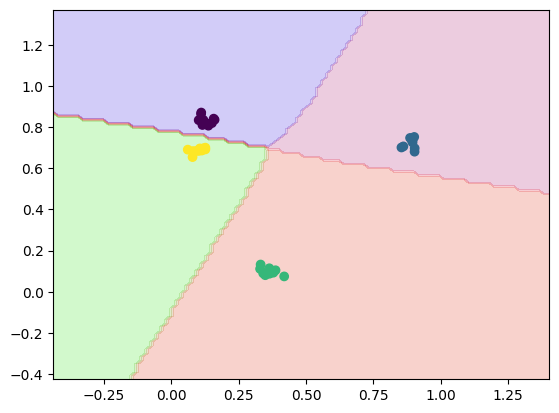

In [20]:
from sklearn.preprocessing import LabelBinarizer

class MLP(BaseEstimator, ClassifierMixin):
  def __init__(self, trainingAlgorithm=BackPropagation()):
    self.trainingAlgorithm = trainingAlgorithm

  def fit(self, X, y):
    self.labelBinarizer = LabelBinarizer()
    y = self.labelBinarizer.fit_transform(y)
    y = y * 2 - 1
    self.w = self.trainingAlgorithm.getWs(X, y)
    return self

  def predict(self, X):
    ypred = self.trainingAlgorithm.foward(X)
    if ypred.shape[1] == 1:
      ypred = sign(ypred)
    else:
      tmp = np.zeros(ypred.shape)
      idx = np.argmax(ypred, axis=1)
      tmp[np.arange(ypred.shape[0]), idx] = 1
      ypred = tmp
    ypred = self.labelBinarizer.inverse_transform(ypred)
    return ypred

model = MLP()
model.fit(X, y)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plotPredictions(model, X)
plotDataset(X, y)
plt.show()

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y, ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



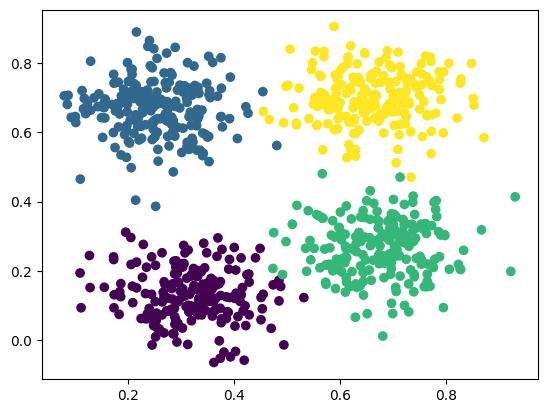

In [26]:
from sklearn.model_selection import train_test_split

def criaDatasetMulticlasse(n=40, n_classes=4):
  X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0,1), cluster_std=0.08)
  return X, y

X, y = criaDatasetMulticlasse(n=1000, n_classes=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
plotDataset(X_train, y_train)

0.99


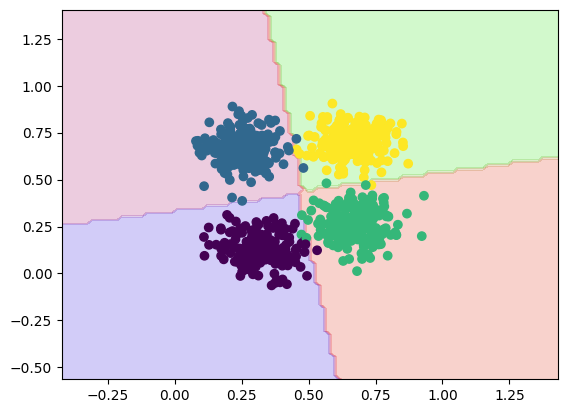

In [32]:
model = MLP(trainingAlgorithm=BackPropagation(max_iter=1000, learning_rate=0.001, n_hidden=[2]))
model.fit(X_train, y_train)
ypred = model.predict(X_train)
print(accuracy_score(y_train, ypred))
plotPredictions(model, X_train)
plotDataset(X_train, y_train)
plt.show()

0.995


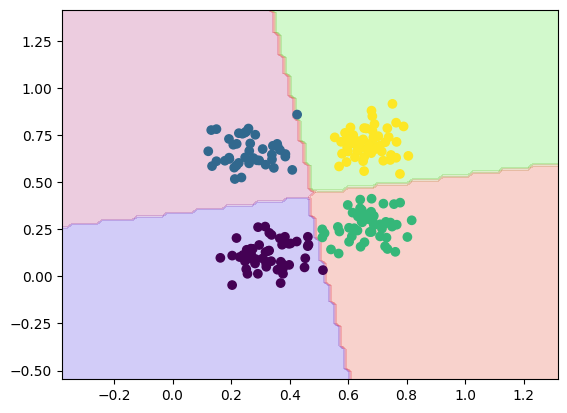

In [33]:
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plotPredictions(model, X_test)
plotDataset(X_test, y_test)
plt.show()